##### Future of Reporting: Agentic AI to enable "listen to your Data" scenarios

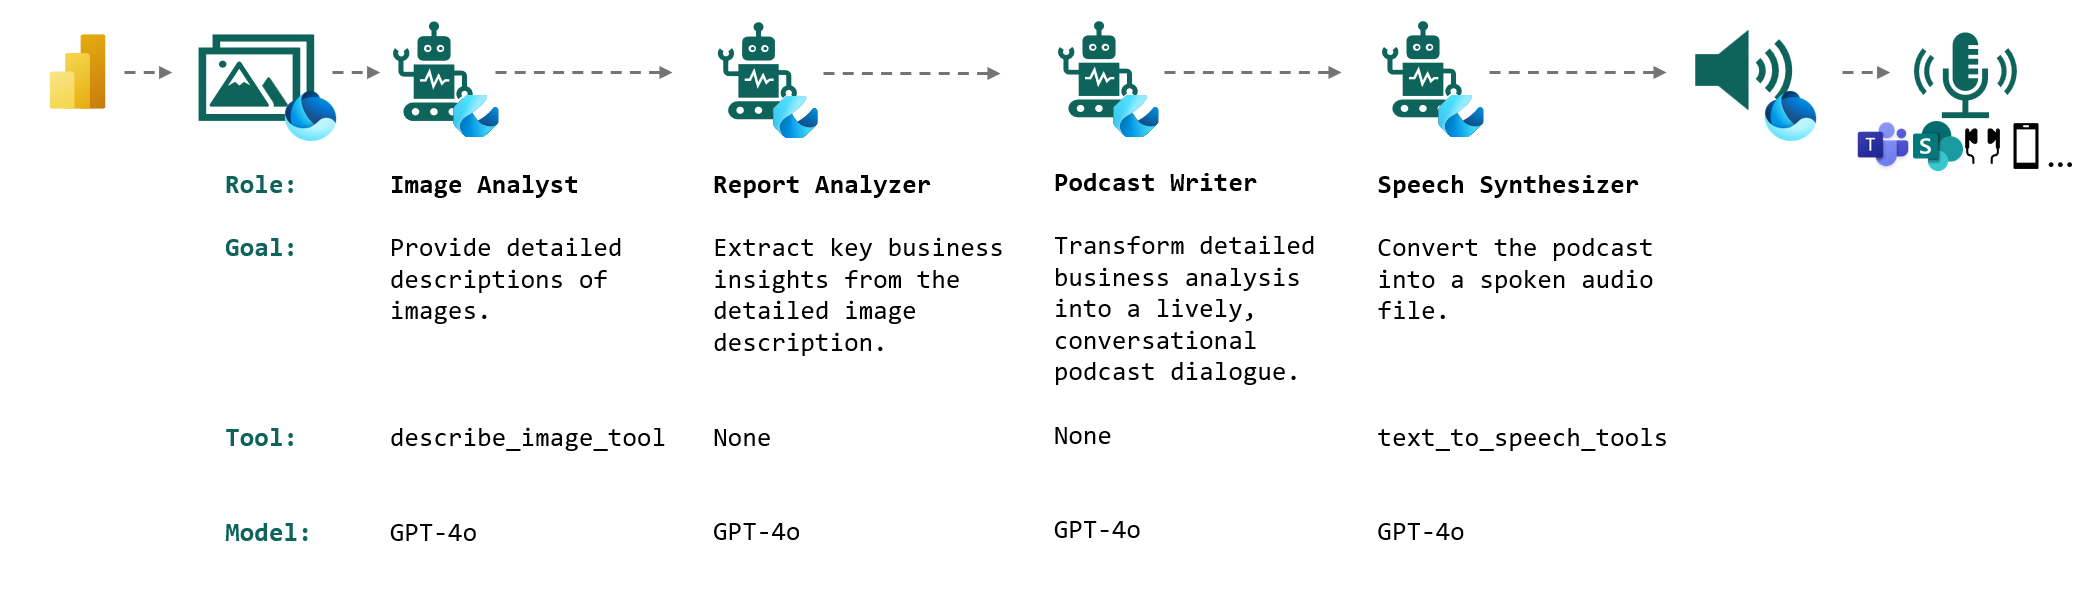

##### Install required packages

In [ ]:
# Leverage Python 3.11+
# Install required packages
%pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community langchain-openai azure-identity python-dotenv pydub azure-cognitiveservices-speech --quiet

##### Setting up Azure Open AI GPT-4o as the LLM

In [ ]:
# Set up Azure Open AI GPT-4o as the LLM to be used by the CrewAI Agents

import os
import certifi
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv

# ===================== CONFIGURABLE VARIABLES =====================
# --- Input Configuration ---
# Load environment variables
load_dotenv(dotenv_path="<insert the lakehouse path where the .env file has been saved>") #Example: "/lakehouse/default/Files/.env"

# ==================================================================

# Set the environment variable 'REQUESTS_CA_BUNDLE' to the path of the certificate bundle provided by certifi
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
# Set the environment variable 'SSL_CERT_FILE' to the path of the certificate bundle provided by certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

# Print environment variables (remove in production)
print("Checking environment variables:")
print(f"Endpoint exists: {'MY_AZURE_OPENAI_ENDPOINT' in os.environ}")
print(f"API Key exists: {'AZURE_OPENAI_KEY' in os.environ}")
print(f"Deployment exists: {'AZURE_OPENAI_MODEL_DEPLOYMENT' in os.environ}")

# Get configuration
api_key = os.getenv("AZURE_OPENAI_KEY")
azure_endpoint = os.getenv("MY_AZURE_OPENAI_ENDPOINT")
deployment_name = os.getenv("AZURE_OPENAI_MODEL_DEPLOYMENT")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# Print configurations (remove sensitive data in production)
print("\nConfiguration values:")
# print(f"Endpoint: {azure_endpoint}")
print(f"Deployment: {deployment_name}")
print(f"API Key length: {len(api_key) if api_key else 0}")
print(f"Api version: {api_version}")

# Initialize Azure OpenAI model
llm = AzureChatOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    azure_deployment=deployment_name,
    api_version=api_version,
)

# Test the connection
try:
    print("\nTesting Azure OpenAI connection...")
    response = llm.invoke("Hello! This is a test message.")
    print("Connection successful!")
    print(f"Response: {response}")
except Exception as e:
    print(f"Error: {str(e)}")
    print(f"Error type: {type(e)}")

##### Multi-Agent Orchestration

In [ ]:
# Set up configurable variables
# Define Agents' Tools
# Define Agent's roles
# Define Agent's tasks
# Run the Agent orchestration

import os
import base64
import tempfile
import time
import re # Import regex for SSML cleanup
from pathlib import Path
from crewai import Agent, Task, Crew
from crewai_tools import tool
from azure.cognitiveservices.speech import SpeechConfig, SpeechSynthesizer, AudioConfig, ResultReason, CancellationReason, SpeechSynthesisOutputFormat
from langchain.schema import HumanMessage, AIMessage

# Assuming 'llm' is already initialized in your environment
global_llm = llm # Make sure llm is assigned here

# ===================== CONFIGURABLE VARIABLES =====================
# --- Input Configuration ---

# Path to the image file to be processed within the Lakehouse environment
LOCAL_IMAGE_PATH = "<insert path to your image file>" #Example: "/lakehouse/default/Files/podcastreport/Contoso_Incidents - (Incident analysis report).png"

# Azure Speech Service Configuration
# IMPORTANT: Ensure the environment variables AZURE_SPEECH_KEY and AZURE_SPEECH_REGION are set in your environment.
AZURE_SPEECH_KEY = os.getenv("AZURE_SPEECH_KEY") # e.g., set AZURE_SPEECH_KEY="your_azure_speech_key" in the .env file
AZURE_SPEECH_REGION = os.getenv("AZURE_SPEECH_REGION") # e.g., set AZURE_SPEECH_REGION="yourazureregion" in the .env file

# Voices for the podcast hosts
# Find available voice names here: https://learn.microsoft.com/en-us/azure/ai-services/speech-service/language-support?tabs=tts
AZURE_SPEECH_VOICE_1 = "<insert Azure voice name for Host 1>" # Example: "en-US-Emma2:DragonHDLatestNeural" or "en-AU-WilliamNeural"
AZURE_SPEECH_VOICE_2 = "<insert Azure voice name for Host 2>"   # Example: "en-US-Andrew3:DragonHDLatestNeural" or "en-AU-NatashaNeural"

# --- Output Configuration ---

# Base name for the final output audio file ('.wav' will be appended automatically)
OUTPUT_FILENAME = "<insert desired base name for the output audio file>" # Example: "test_analysis_podcast"

# Directory path where the final audio file will be saved. Ensure this path exists or is writable. Must end with a forward slash '/'.
DEFAULT_OUTPUT_FILEPATH = "<insert path to the desired output directory>" # Example: "/lakehouse/default/Files/podcastreport/"

# --- Derived Configuration (Do Not Modify Manually Below This Line) ---

# Derive language automatically from the first voice for SSML tag
AZURE_SPEECH_LANG = "en-US" # Default fallback
try:
    # Check if AZURE_SPEECH_VOICE_1 is not None or empty before attempting split
    if AZURE_SPEECH_VOICE_1 and isinstance(AZURE_SPEECH_VOICE_1, str) and AZURE_SPEECH_VOICE_1.startswith('<'):
        print(f"Warning: AZURE_SPEECH_VOICE_1 seems to contain a placeholder '{AZURE_SPEECH_VOICE_1}'. Using default language '{AZURE_SPEECH_LANG}'. Please replace the placeholder.")
    elif AZURE_SPEECH_VOICE_1 and isinstance(AZURE_SPEECH_VOICE_1, str):
         parts = AZURE_SPEECH_VOICE_1.split('-')
         if len(parts) >= 2:
             AZURE_SPEECH_LANG = f"{parts[0]}-{parts[1]}"
         else:
              print(f"Warning: Could not reliably determine language from voice '{AZURE_SPEECH_VOICE_1}'. Using default '{AZURE_SPEECH_LANG}'.")
    elif AZURE_SPEECH_VOICE_1 is None:
         print(f"Warning: AZURE_SPEECH_VOICE_1 is not set. Using default language '{AZURE_SPEECH_LANG}'.")

except Exception as e:
    print(f"Warning: Error parsing voice name for language '{AZURE_SPEECH_VOICE_1}': {e}. Using default '{AZURE_SPEECH_LANG}'.")

# Construct the full output file path
DEFAULT_OUTPUT_FILENAME = f"{OUTPUT_FILENAME}.wav"
OUTPUT_FILE_PATH = DEFAULT_OUTPUT_FILEPATH + DEFAULT_OUTPUT_FILENAME

# MIME type mappings (Generally constant)
MIME_TYPES = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}
# ==================================================================

# --- File and Credential Checks ---
print(f"--- Configuration Summary ---")
print(f"Input Image Path: {LOCAL_IMAGE_PATH}")
if not LOCAL_IMAGE_PATH or LOCAL_IMAGE_PATH.startswith("<"):
    print("Warning: Input image path appears to be a placeholder or empty. Please update the LOCAL_IMAGE_PATH variable.")
    # Optionally raise an error if you want to force the user to change it:
    # raise ValueError("Please replace the placeholder value for LOCAL_IMAGE_PATH before running.")
elif not os.path.exists(LOCAL_IMAGE_PATH):
    print(f"Error: Input image file NOT found at: {LOCAL_IMAGE_PATH}")
    raise FileNotFoundError(f"Could not find image at the specified LOCAL_IMAGE_PATH: {LOCAL_IMAGE_PATH}")
else:
    print("Input image file found.")

print(f"Azure Speech Region: {AZURE_SPEECH_REGION}")
if not AZURE_SPEECH_KEY:
    print("Warning: AZURE_SPEECH_KEY environment variable not found or empty.")
    # Optionally raise an error
    # raise ValueError("Azure Speech Key (AZURE_SPEECH_KEY) environment variable not set.")
if not AZURE_SPEECH_REGION:
    print("Warning: AZURE_SPEECH_REGION environment variable not found or empty.")
    # Optionally raise an error
    # raise ValueError("Azure Speech Region (AZURE_SPEECH_REGION) environment variable not set.")

print(f"Host 1 Voice: {AZURE_SPEECH_VOICE_1}")
print(f"Host 2 Voice: {AZURE_SPEECH_VOICE_2}")
print(f"Derived SSML Language: {AZURE_SPEECH_LANG}")
print(f"Output Base Filename: {OUTPUT_FILENAME}")
print(f"Output Directory: {DEFAULT_OUTPUT_FILEPATH}")
print(f"Full Output Path: {OUTPUT_FILE_PATH}")
print(f"----------------------------")

# Pre-flight check for output directory
output_dir = os.path.dirname(OUTPUT_FILE_PATH)
if output_dir and not os.path.exists(output_dir):
    print(f"Warning: Output directory '{output_dir}' does not exist. Attempting to create it.")
    try:
        os.makedirs(output_dir, exist_ok=True) # Use exist_ok=True
        print(f"Successfully created output directory: {output_dir}")
    except OSError as e:
        print(f"Error: Failed to create output directory '{output_dir}': {e}")
        raise # Re-raise the error to stop execution if directory creation fails
# --- End Checks ---


# ======================= TOOLS =======================

@tool("Image Description Tool")
def describe_image(local_image_path: str) -> str:
    """
    Analyzes and describes images in detail.
    Provide the full path to the image file you want to describe.
    """
    # --- (describe_image tool) ---
    try:
        # Access the global LLM
        llm = global_llm
        if llm is None:
             return "Error: LLM not provided to the tool. Make sure to set global_llm before using this tool."
        # Print debug info
        print(f"Tool received path: {local_image_path}")
        # Convert to Path object
        image_path = Path(local_image_path)
        # Double-check file exists
        if not image_path.exists():
            print(f"Error: Image file not found at {image_path}")
            return f"Error: Image file not found at {image_path}"
        else:
            print(f"Tool confirmed file exists at {image_path}")
        # Read and encode image to base64
        with open(image_path, "rb") as img_file:
            img_data = base64.b64encode(img_file.read()).decode("utf-8")
            file_size = os.path.getsize(image_path)
            print(f"Successfully read image file. Size: {file_size} bytes")
        # Get the MIME type
        extension = image_path.suffix.lower()
        mime_type = MIME_TYPES.get(extension, "application/octet-stream")
        print(f"Using MIME type: {mime_type}")
        # Format image content for Azure OpenAI
        image_content = f"data:{mime_type};base64,{img_data}"
        # Use the image_content with Azure OpenAI
        print("Sending image to Azure OpenAI for description...")
        try:
            # Create a message with the image
            message = HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "Please describe this image in detail, focusing on any text, charts, graphs, or data presented:" # Slightly tuned prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": image_content
                        }
                    }
                ]
            )
            # Get the response from Azure OpenAI
            response = llm.invoke([message])
            print("Received response from Azure OpenAI")
            # Extract the content from the response
            if isinstance(response, AIMessage):
                return response.content
            else:
                return str(response)
        except Exception as llm_error:
            print(f"LLM error: {str(llm_error)}")
            return f"Error getting image description from LLM: {str(llm_error)}"
    except Exception as e:
        print(f"Error in tool: {str(e)}")
        return f"Error processing image: {str(e)}"
    # --- (End of describe_image code) ---


@tool("SSML Formatter Tool")
def format_ssml_tool(dialogue_content: str) -> str:
    """
    Takes podcast dialogue text (expected to contain <voice> tags already)
    and wraps it in the necessary <speak> root element for Azure SSML,
    dynamically setting the xml:lang attribute based on the configured primary voice.
    It cleans up potential extra whitespace or markdown code fences.
    Provide the raw dialogue content generated by the scriptwriter.
    """
    # --- (format_ssml_tool) ---
    print("SSML Formatter Tool: Received dialogue content.")
    ssml_body = str(dialogue_content).strip()

    # Remove potential markdown code fences added by LLM
    ssml_body = re.sub(r'^```xml\s*', '', ssml_body, flags=re.IGNORECASE | re.MULTILINE)
    ssml_body = re.sub(r'\s*```$', '', ssml_body, flags=re.MULTILINE)
    ssml_body = ssml_body.strip()

    lang_attribute = f'xml:lang="{AZURE_SPEECH_LANG}"'
    is_already_wrapped = ssml_body.startswith('<speak') and ssml_body.endswith('</speak>')
    has_correct_lang = lang_attribute in ssml_body[:150]

    if is_already_wrapped and has_correct_lang:
        print(f"SSML Formatter Tool: Input already correctly wrapped with {lang_attribute}.")
        return ssml_body
    elif is_already_wrapped and not has_correct_lang:
        print(f"SSML Formatter Tool: Input wrapped, but ensuring correct {lang_attribute}.")
        pattern = re.compile(r'(<speak[^>]*)(\s*xml:lang="[^"]*")?([^>]*>)', re.IGNORECASE)
        if pattern.search(ssml_body):
             ssml_body = pattern.sub(rf'\1 {lang_attribute}\3', ssml_body, count=1)
        else:
             ssml_body = ssml_body.replace('<speak', f'<speak {lang_attribute}', 1)
        return ssml_body
    else:
        print(f"SSML Formatter Tool: Wrapping dialogue content with {lang_attribute}.")
        ssml_full = f'<speak version="1.0" xmlns="http://www.w3.org/2001/10/synthesis" {lang_attribute}>\n{ssml_body}\n</speak>'
        return ssml_full
    # --- (End of format_ssml_tool code) ---

@tool("SSML to Speech Tool")
def ssml_to_speech(ssml_input: str) -> str:
    """
    Converts a **complete and valid** SSML string (including the root <speak> tag
    with correct xml:lang, and <voice> tags defining multiple voices) into speech
    and saves it as a single WAV file. Provide the full, validated SSML string.
    Use the 'SSML Formatter Tool' first to ensure validity.
    """
    # --- (Keep the ssml_to_speech tool code as corrected previously) ---
    # ... (code from previous version for ssml_to_speech) ...
    try:
        # Credentials check
        speech_config = SpeechConfig(subscription=AZURE_SPEECH_KEY, region=AZURE_SPEECH_REGION)
        speech_config.set_speech_synthesis_output_format(SpeechSynthesisOutputFormat.Riff24Khz16BitMonoPcm)

        ssml_content = str(ssml_input)

        if not ssml_content.strip().startswith('<speak'):
            print(f"Warning in ssml_to_speech: Input SSML might be invalid (missing <speak> tag): {ssml_content[:100]}...")

        print(f"SSML to Speech Tool: Processing SSML (language should be embedded within): '{ssml_content[:150]}...'")
        print(f"Output will be saved to: {OUTPUT_FILE_PATH}")

        if not ssml_content:
            return "Error: No SSML content provided for speech synthesis."

        output_dir = os.path.dirname(OUTPUT_FILE_PATH)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir); print(f"Created output directory: {output_dir}")

        audio_config = AudioConfig(filename=OUTPUT_FILE_PATH)
        synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config)

        print("Synthesizing SSML...")
        result = synthesizer.speak_ssml_async(ssml_content).get()

        del synthesizer; del audio_config; time.sleep(0.1)

        if result.reason == ResultReason.SynthesizingAudioCompleted:
            wait_time = 0
            while not (os.path.exists(OUTPUT_FILE_PATH) and os.path.getsize(OUTPUT_FILE_PATH) > 0) and wait_time < 5:
                time.sleep(0.5); wait_time += 0.5
            if not (os.path.exists(OUTPUT_FILE_PATH) and os.path.getsize(OUTPUT_FILE_PATH) > 0):
                 return f"Error: Output file {OUTPUT_FILE_PATH} is missing or empty after synthesis completed."
            else:
                 print(f"SSML synthesis successful. File saved to {OUTPUT_FILE_PATH} ({os.path.getsize(OUTPUT_FILE_PATH)} bytes).")
                 return f"Speech synthesis successful. File saved at: {OUTPUT_FILE_PATH}"
        elif result.reason == ResultReason.Canceled:
            cancellation_details = result.cancellation_details
            error_message = f"SSML synthesis canceled. Reason: {cancellation_details.reason}"
            if cancellation_details.reason == CancellationReason.Error:
                print(f"Cancellation Error Code: {cancellation_details.error_code}")
                print(f"Cancellation Error Details: {cancellation_details.error_details}")
                error_message += f" Error details: {cancellation_details.error_details}"
            print(error_message)
            if os.path.exists(OUTPUT_FILE_PATH):
                try: os.remove(OUTPUT_FILE_PATH)
                except OSError as remove_err: print(f"Warning: Could not remove partially created file {OUTPUT_FILE_PATH}: {remove_err}")
            return error_message
        else:
             error_message = f"Unexpected SSML synthesis result: {result.reason}"
             print(error_message)
             if os.path.exists(OUTPUT_FILE_PATH):
                 try: os.remove(OUTPUT_FILE_PATH)
                 except OSError as remove_err: print(f"Warning: Could not remove potentially invalid file {OUTPUT_FILE_PATH}: {remove_err}")
             return error_message

    except Exception as e:
        import traceback
        print(f"Error in ssml_to_speech function: {str(e)}")
        print(traceback.format_exc())
        if os.path.exists(OUTPUT_FILE_PATH):
            try: os.remove(OUTPUT_FILE_PATH)
            except OSError as remove_err: print(f"Warning: Could not remove file {OUTPUT_FILE_PATH} during exception handling: {remove_err}")
        return f"Error during SSML to speech processing: {str(e)}"
    # --- (End of ssml_to_speech code) ---


# ======================= AGENTS =======================

image_analyst = Agent(
    role="Image Analyst",
    goal="Provide comprehensive and objective textual descriptions of images, capturing all relevant visual details, especially focusing on text, charts, graphs, or data presented.",
    backstory="You're an expert at analyzing and describing visual content with meticulous attention to detail, skilled at extracting factual information from images.",
    verbose=True, allow_delegation=False, llm=global_llm, tools=[describe_image]
)

# --- NEW Report Analyzer Agent ---
report_analyzer = Agent(
    role="Business Report Analyzer",
    goal=(
        "Analyze the provided detailed image description (containing text, charts, data etc.) "
        "to extract key business insights, trends, figures, and potential implications. "
        "Synthesize these findings into a structured written analysis presented as an essay, "
        "starting with a concise Executive Summary."
        ),
    backstory=(
        "You are a meticulous business analyst skilled at interpreting data presented visually (via its textual description). "
        "You excel at identifying significant patterns, summarizing complex information clearly, "
        "and presenting actionable findings in a well-structured report format suitable for executive review and communication planning."
        ),
    verbose=True,
    allow_delegation=False,
    llm=global_llm
    # This agent primarily works on text context, no specific tool needed beyond LLM capabilities.
)

# --- Podcast Writer Agent (Now takes analysis as input) ---
podcast_writer = Agent(
    role="Podcast Dialogue Creator",
    goal=(
        "My main goal is to take that detailed business analysis report and turn it into a friendly, engaging chat between two podcast hosts. "
        "I'll write the script so it sounds natural, making sure to tag each host's lines correctly (using `<voice name='...'>` tags with the specific voices: "
        f"'{AZURE_SPEECH_VOICE_1}' for Host 1 and '{AZURE_SPEECH_VOICE_2}' for Host 2) so the final audio sounds great. "
        "I'll also do my best to wrap the whole thing in the main `<speak>` tags needed for the audio generation step."
    ),
    backstory=(
        "Think of me as your creative partner who's great at taking serious reports and making them easy to understand and interesting to listen to. "
        "I specialize in writing natural-sounding conversations for two people, making sure all the important points from the analysis are covered clearly. "
        "I know how to set up the script with the right formatting (like those `<voice>` tags) so it's ready for the next step of actually creating the audio."
    ),
    verbose=True, allow_delegation=False, llm=global_llm
)

# --- Speech Synthesizer Agent (Keep as before) ---
speech_synthesizer = Agent(
    role="SSML Formatting and Speech Synthesis Orchestrator",
    goal=(
        "Take raw podcast dialogue, format it into valid SSML using the SSML Formatter Tool (which sets the correct language based on configuration), "
        "and then convert the finalized SSML into a single high-quality spoken audio file using the SSML to Speech Tool."
        ),
    backstory=(
        "You are an expert workflow manager for audio production. You first ensure the script is perfectly formatted as SSML with the correct language, "
        "then you use Azure's Text-to-Speech service to generate seamless, multi-voice audio output from the validated SSML."
        ),
    verbose=True, llm=global_llm, tools=[format_ssml_tool, ssml_to_speech]
)


# ======================= TASKS =======================

image_task = Task(
    description=(
        f"Analyze the image located at {LOCAL_IMAGE_PATH}. Provide a comprehensive and objective textual description "
        "detailing all visible elements, scenes, objects, text, charts, graphs, and any discernible context or data presented visually. "
        "This description will be used by the Business Report Analyzer."
    ),
    agent=image_analyst,
    expected_output="A detailed, objective textual description of the image's contents, focusing on data and textual elements."
)

# --- Analysis Task ---
analysis_task = Task(
    description=(
        "Review the detailed image description provided in the context. "
        "Based *solely* on the information presented in that description (text, data points, chart descriptions etc.), "
        "perform a thorough business analysis. Identify key insights, significant trends, important figures, and potential implications. "
        "Structure your findings as a written essay. Start with a clear 'Executive Summary' section summarizing the main points, "
        "followed by a more detailed 'Analysis' section elaborating on the findings. "
        "This report will be used to create a podcast script."
    ),
    agent=report_analyzer,
    expected_output=(
        "A well-structured written analysis in essay format. "
        "It MUST begin with an 'Executive Summary' section. "
        "It MUST be followed by a detailed 'Analysis' section. "
        "The analysis must be based ONLY on the information from the input image description."
    ),
    context=[image_task] # Depends on the image description
)

# --- Business Update Task (it depends on analysis_task) ---
business_update_task = Task(
    description=(
        "Okay, I have the business analysis report here (check the context). My task is to translate the key findings and insights from this report "
        "into a natural, back-and-forth dialogue for a podcast featuring Host 1 and Host 2. The conversation should flow well and make the analysis easy for listeners to grasp. "
        "\n\n**Formatting Guide for Audio:**\n" # Use markdown for emphasis
        f"*   **Host 1:** Use the `<voice name=\"{AZURE_SPEECH_VOICE_1}\">...</voice>` tag for everything Host 1 says.\n"
        f"*   **Host 2:** Use the `<voice name=\"{AZURE_SPEECH_VOICE_2}\">...</voice>` tag for everything Host 2 says.\n"
        "*   **Structure:** Please alternate between these tags as the hosts speak. Getting these voice tags right is crucial for the audio step!\n"
        "*   **Wrapping (Optional but helpful):** If you can, please also wrap the entire dialogue within the main `<speak>...</speak>` tags.\n"
        "*   **Content:** Just include the words the hosts will actually say. No extra labels like 'Host 1:', notes about music, or markdown formatting around the SSML itself."
    ),
    agent=podcast_writer,
    expected_output=(
         "A complete podcast script formatted as dialogue. It should feature alternating "
         f"`<voice name='{AZURE_SPEECH_VOICE_1}'>...</voice>` and `<voice name='{AZURE_SPEECH_VOICE_2}'>...</voice>` tags "
         "containing the spoken lines for each host, accurately reflecting the input analysis in a conversational style. "
         "Ideally, the whole script will be enclosed in `<speak>...</speak>` tags."
    ),
    context=[analysis_task] # Depends on the analysis report
)

# --- Speech Task (it depends on business_update_task) ---
speech_task = Task(
    description=(
        "Process the podcast dialogue script received from the previous task (available in context). "
        "Step 1: Use the 'SSML Formatter Tool' to ensure the script is wrapped in valid `<speak>...</speak>` tags with the correct language attribute (derived automatically from config). "
        "Step 2: Take the **output** from the 'SSML Formatter Tool' and use the 'SSML to Speech Tool' to synthesize this final, validated SSML into a single audio track. "
        f"Ensure the final audio is saved correctly as a .wav file to the path '{OUTPUT_FILE_PATH}'. "
        "Report success or failure, including the output path on success or detailed error messages on failure."
    ),
    agent=speech_synthesizer,
    expected_output=(
        "Confirmation of successful audio file generation from the formatted SSML input, including the "
        f"file path where the .wav file was saved (expected: {OUTPUT_FILE_PATH}), or a descriptive error message if any step failed."
    ),
    context=[business_update_task] # Depends on the SSML script
)

# ======================= CREW EXECUTION =======================
if __name__ == "__main__":
    # Make sure global_llm is set
    if 'global_llm' not in globals() or global_llm is None:
        raise ValueError("The 'llm' variable is not defined or not assigned to 'global_llm'. Please ensure your LLM is initialized.")

    print(f"\n--- Starting Crew Workflow ---")
    print(f"Image Path: {LOCAL_IMAGE_PATH}")
    print(f"Output Audio Path: {OUTPUT_FILE_PATH}")
    print(f"Host 1 Voice (Azure): {AZURE_SPEECH_VOICE_1}")
    print(f"Host 2 Voice (Azure): {AZURE_SPEECH_VOICE_2}")
    print(f"--> Derived SSML Language: {AZURE_SPEECH_LANG}")
    print(f"----------------------------\n")

    # --- Updated Crew Definition ---
    crew = Crew(
        agents=[
            image_analyst,
            report_analyzer, # Added agent
            podcast_writer,
            speech_synthesizer
        ],
        tasks=[
            image_task,
            analysis_task, # Added task
            business_update_task,
            speech_task
        ],
        verbose=2 # Use verbose=2 for detailed logs
    )
    # --- End Updated Crew Definition ---

    # Execute the crew workflow
    print("\n--- Kicking off Crew ---")
    result = crew.kickoff()
    print("\n--- Crew Workflow Finished ---")
    print("Final result from Crew:", result)

    # --- Post-Run Verification (Keep as before) ---
    print(f"\n--- Post-Run Verification ---")
    if os.path.exists(OUTPUT_FILE_PATH):
        print(f"Success: Output audio file found at: {OUTPUT_FILE_PATH}")
        print(f"File size: {os.path.getsize(OUTPUT_FILE_PATH)} bytes")
    else:
        print(f"Error: Output audio file NOT found at the expected path: {OUTPUT_FILE_PATH}")
        print("Please check the logs above for errors during the analysis, formatting or synthesis tasks.")
    print(f"---------------------------\n")